![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Librerías a Importar

In [2]:
# Prevención de alertas
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [4]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [6]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

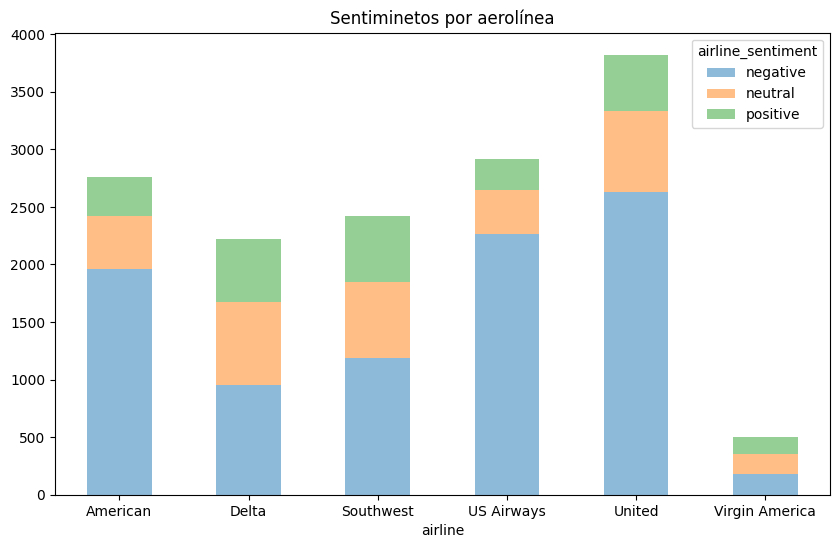

In [8]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Separación de Datos en Conjunto de Entrenamiento y Evaluación

In [9]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':0,'neutral':1,'positive':2})

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [11]:
# Aplicación de CountVectorizer para convertir el texto en una matriz de conteo
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [16]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_count, y_train)

In [17]:
# Entrenamiento y predicción del modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)
y_pred_rf = rf_model.predict(X_test_count)

In [18]:
# Evaluación del modelo con el conjunto de test
accuracy_RF = accuracy_score(y_test, y_pred_rf)
Reporte_RF = classification_report(y_test, y_pred_rf)
Matriz_conf_RF = confusion_matrix(y_test, y_pred_rf)

# Mostramos los resultados
print(f" Accuracy del modelo: {accuracy_RF:.4f}")
print("\n Reporte de clasificación:\n", Reporte_RF)
print("\n Matriz de confusión:\n", Matriz_conf_RF)

 Accuracy del modelo: 0.7649

 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      3085
           1       0.58      0.54      0.56       984
           2       0.71      0.54      0.61       763

    accuracy                           0.76      4832
   macro avg       0.71      0.66      0.68      4832
weighted avg       0.76      0.76      0.76      4832


 Matriz de confusión:
 [[2751  257   77]
 [ 360  532   92]
 [ 228  122  413]]


#### Análisis Modelo con CountVectorizer
<p style="text-align: justify;">
Este modelo presenta un buen desempeño particularmente en la clase 0; en términos generales el modelo obtuvo una exactitud del 76.49%. La clase 0 (<code>'negative'</code>) presentó una precisión de 0.83 y recall de 0.89, mientras que las clases 1 (<code>'neutral'</code>) y 2 (<code>'positive'</code>) tuvieron un recall más bajo (0.54 en ambos casos). La matriz de confusión confirma más errores en estas últimas clases. El desbalance de clases en los datos podría estar influyendo en los resultados.<p>

### Punto 2 - Eliminación de Stopwords
<p style="text-align: justify;">
En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.<p>

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [19]:
# Limpieza de texto
lemmatizer = WordNetLemmatizer()                                          # Inicializamos el lematizador
def limpiar_texto(texto):
    stop_words = set(stopwords.words('english'))                          # Lista de stopwords 
    tokens = wordpunct_tokenize(texto)                                    # Separamos el texto por palabras (tokens)
        
    tokens_filtrados = [p for p in tokens if p.lower() not in stop_words and p.isalpha()]   
    return ' '.join(tokens_filtrados)

# Aplicación de la función de limpieza a los textos
X_train_limpio = X_train.apply(limpiar_texto)
X_test_limpio = X_test.apply(limpiar_texto)

In [20]:
# Convertimos los textos a vectores usando CountVectorizer
vectorizador = CountVectorizer()
X_train_vec = vectorizador.fit_transform(X_train_limpio)
X_test_vec = vectorizador.transform(X_test_limpio)

In [21]:
# Balanceo de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

In [22]:
# Creamos y entrenamos el modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_res, y_train_res)

# Hacemos predicciones y evaluamos el modelo
predicciones = modelo_rf.predict(X_test_vec)

# Métricas de desempeño
accuracy_StopWords = accuracy_score(y_test, predicciones)
reporte = classification_report(y_test, predicciones)
matriz_conf = confusion_matrix(y_test, predicciones)

# Mostramos los resultados
print(" Accuracy del modelo combinado:", accuracy_StopWords)
print("\n Reporte de clasificación:\n", reporte)
print("\n Matriz de confusión:\n", matriz_conf)

 Accuracy del modelo combinado: 0.734271523178808

 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      3085
           1       0.50      0.59      0.54       984
           2       0.62      0.66      0.64       763

    accuracy                           0.73      4832
   macro avg       0.66      0.68      0.67      4832
weighted avg       0.75      0.73      0.74      4832


 Matriz de confusión:
 [[2464  452  169]
 [ 263  584  137]
 [ 129  134  500]]


#### Modelo de análisis CountVectorizer + Stopwords
<p style="text-align: justify;">
Este modelo presenta un desempeño general inferior al anterior con una exactitud de 73.43%. La clase 0 (<code>'negative'</code>) presentó una precisión de 0.86 y recall de 0.80, mientras que las clases 1 (<code>'neutral'</code>), disminuyó en su precisión 0.50 y aumentó en su recall 0.59 y 2 (<code>'positive'</code>) disminiyó en precisión (0.62) y aumentó en recall (0.66). Estos resultados pueden interpretarse de la siguiente manera: El modelo presenta menor precisión en términos generales, predice un poco mejor la clase 0 (<code>'negative'</code>), es decir encuentra mejor los verdaderos positivos a un costo de más fálsos negativos.
<p style="text-align: justify;">
al comparar las matrices de confusión, se concluye que este modelo es más preciso, con un total de 500 aciertos, contra los 413 del modelo original. 

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [23]:
# Creamos una función que limpie el texto
# Quitamos palabras vacías y lematizamos las palabras restantes
lemmatizer = WordNetLemmatizer()  # Inicializamos el lematizador
def limpiar_texto(texto):
    #stop_words = set(stopwords.words('english'))  # Lista de stopwords 
    tokens = wordpunct_tokenize(texto)  # Separamos el texto por palabras (tokens)
    
    # Filtramos las palabras: que no sean stopwords y que sean letras (no signos)
    #tokens_filtrados = [p for p in tokens if p.lower() not in stop_words and p.isalpha()]
    
    # Lematizamos usando como referencia los verbos
    lematizadas = [lemmatizer.lemmatize(p, pos='v') for p in tokens]
    
    # Unimos todo nuevamente en un texto limpio
    return ' '.join(lematizadas)

# Aplicamos esta limpieza a los datos de entrenamiento y prueba
X_train_limpio = X_train.apply(limpiar_texto)
X_test_limpio = X_test.apply(limpiar_texto)

# Convertimos los textos a vectores usando CountVectorizer
vectorizador = CountVectorizer()
X_train_vec = vectorizador.fit_transform(X_train_limpio)
X_test_vec = vectorizador.transform(X_test_limpio)


In [24]:
# Creamos y entrenamos el modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_vec, y_train)

# Hacemos predicciones y evaluamos el modelo
predicciones = modelo_rf.predict(X_test_vec)

# Métricas de desempeño
accuracy_lemmatizer = accuracy_score(y_test, predicciones)
reporte = classification_report(y_test, predicciones)
matriz_conf = confusion_matrix(y_test, predicciones)

# Mostramos los resultados
print(" Accuracy del modelo combinado:", accuracy_lemmatizer)
print("\n Reporte de clasificación:\n", reporte)
print("\n Matriz de confusión:\n", matriz_conf)

 Accuracy del modelo combinado: 0.7706953642384106

 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86      3085
           1       0.69      0.41      0.52       984
           2       0.83      0.45      0.58       763

    accuracy                           0.77      4832
   macro avg       0.77      0.61      0.65      4832
weighted avg       0.77      0.77      0.75      4832


 Matriz de confusión:
 [[2976   86   23]
 [ 533  405   46]
 [ 326   94  343]]


#### Modelo de análisis CountVectorizer + Stopwords + Lematización
<p style="text-align: justify;">
Este modelo presenta un desempeño general inferior al anterior con una exactitud de 77.06%. La clase 0 (<code>'negative'</code>) presentó una precisión de 0.78 y recall de 0.96, mientras que las clases 1 (<code>'neutral'</code>), aumenta en su precisión 0.69 y disminuye en su recall 0.41 y 2 (<code>'positive'</code>) aumentó en su precisión (0.83) y disminuye en recall (0.45). Estos resultados pueden interpretarse de la siguiente manera: El modelo presenta una mejora considerable en su precisión en todas las clases, es decir encuentra mejor los verdaderos positivos a un costo de más fálsos negativos en todas las clases.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [22]:
# Creamos una función que limpie el texto
# Quitamos palabras vacías y lematizamos las palabras restantes
lemmatizer = WordNetLemmatizer()  # Inicializamos el lematizador
def limpiar_texto(texto):
    stop_words = set(stopwords.words('english'))  # Lista de stopwords 
    tokens = wordpunct_tokenize(texto)  # Separamos el texto por palabras (tokens)
    
    # Filtramos las palabras: que no sean stopwords y que sean letras (no signos)
    tokens_filtrados = [p for p in tokens if p.lower() not in stop_words and p.isalpha()]
    
    # Lematizamos usando como referencia los verbos
    lematizadas = [lemmatizer.lemmatize(p, pos='v') for p in tokens_filtrados]
    
    # Unimos todo nuevamente en un texto limpio
    return ' '.join(lematizadas)

# Aplicamos esta limpieza a los datos de entrenamiento y prueba
X_train_limpio = X_train.apply(limpiar_texto)
X_test_limpio = X_test.apply(limpiar_texto)

# Convertimos los textos a vectores usando CountVectorizer
vectorizador = CountVectorizer()
X_train_vec = vectorizador.fit_transform(X_train_limpio)
X_test_vec = vectorizador.transform(X_test_limpio)

In [23]:
# Creamos y entrenamos el modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_vec, y_train)

# Hacemos predicciones y evaluamos el modelo
predicciones = modelo_rf.predict(X_test_vec)

# Métricas de desempeño
accuracy_combined= accuracy_score(y_test, predicciones)
reporte = classification_report(y_test, predicciones)
matriz_conf = confusion_matrix(y_test, predicciones)

# Mostramos los resultados
print(" Accuracy del modelo combinado:", accuracy_combined)
print("\n Reporte de clasificación:\n", reporte)
print("\n Matriz de confusión:\n", matriz_conf)


 Accuracy del modelo combinado: 0.7731788079470199

 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      3085
           1       0.62      0.45      0.52       984
           2       0.74      0.61      0.67       763

    accuracy                           0.77      4832
   macro avg       0.72      0.66      0.68      4832
weighted avg       0.76      0.77      0.76      4832


 Matriz de confusión:
 [[2829  181   75]
 [ 453  445   86]
 [ 204   97  462]]


#### Modelo aplicando múltiples técnicas
<p style="text-align: justify;">
Este modelo presenta el mejor desempeño con una exactitud de 77.07 %. La clase 0 (<code>'negative'</code>) presentó una precisión de 0.81 y recall de 0.92, mientras que las clases 1 (<code>'neutral'</code>), con precisión 0.62 y recall 0.45 y 2 (<code>'positive'</code>) con precisión (0.74) y recall (0.61). Estos resultados pueden interpretarse como un modelo mucho más equilibrado que tiene un muy buen poder predictivo tanto en los casos positivos como negativos y en las diferentes clases (su menor desempeño sigue dado por la clase 1 (<code>'neutral'</code>).

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

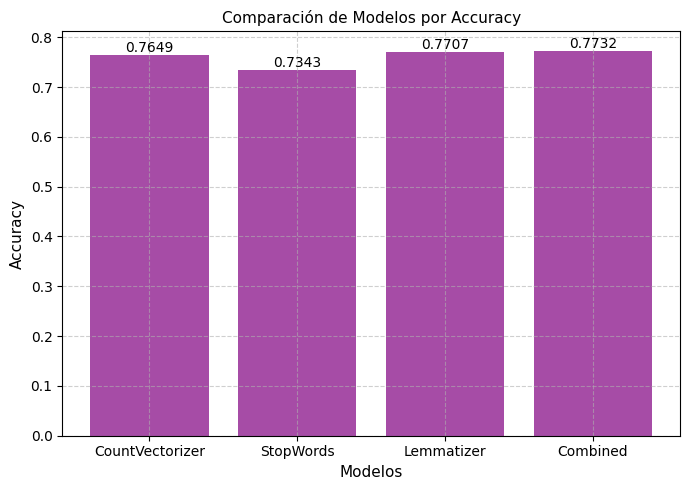

In [24]:
modelos = ['CountVectorizer', 'StopWords', 'Lemmatizer', 'Combined']
Accuracy = [accuracy_RF, accuracy_StopWords, accuracy_lemmatizer, accuracy_combined]

fig, ax = plt.subplots(figsize=(7, 5))

# Color púrpura
purple_color = '#800080'

# Gráfico: Comparar modelos por MSE
bars = ax.bar(modelos, Accuracy, color=purple_color, alpha=0.7)
ax.set_title('Comparación de Modelos por Accuracy', fontsize=11)
ax.set_xlabel('Modelos', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

# Mostrar el valor arriba de cada barra
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', 
            ha='center', va='bottom', fontsize=10)

# Ajustes finales
plt.tight_layout()
plt.show()


<p style="text-align: justify;">
Al comparar el desemepeño de todos los modelos se observa que el modelo que utiliza CountVectorizer obtuvo un accuracy de 0.7649. Al eliminar stopwords, el accuracy disminuyó a 0.7343. La aplicación de la lematización mejoró el accuracy a 0.7707. El modelo Combined, que integra la eliminación de stopwords y la lematización, mostró el accuracy más alto con un valor de 0.7732, superando a los modelos individuales. Esto sugiere que la combinación de ambas técnicas de preprocesamiento contribuye a un mejor rendimiento del modelo según la métrica de desepeño seleccionada.<p>